In [2]:
import pandas as pd
import ast

# Function to get crypto price
def get_crypto_prices(crypto = "BTC"):
    columns = {"ticker":[], "date":[], "open":[], "high":[], "low":[], "close":[]}
    df = pd.DataFrame(data=columns)
    try:
        df = pd.read_csv(f'../crypto_prices/{crypto}.csv')
    except FileNotFoundError as e:
        print(f"Could not find file {crypto}") 
    return df

# Function to get crypto news
def get_crypto_news():
    df = pd.read_csv(f'../crypto_news/cryptonews.csv')
    df['date'] = df["date"].str[:10].str.strip()
    df['date'] = pd.to_datetime(df['date'])
    # df.set_index("date", inplace=True)
    return df



In [3]:
import ta
from sklearn.preprocessing import MinMaxScaler
import ta.volatility
from sklearn.model_selection import train_test_split



# get crypto prices
df = get_crypto_prices("BTC")

# Adds derived fields using Technical Analylsis Library
df['MA_10'] = df['close'].rolling(window=10).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()
df['RSI'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['MACD'] = ta.trend.MACD(df['close']).macd()
df['MACD_signal'] = ta.trend.MACD(df['close']).macd_signal()
df['ADX_Indicator'] = ta.trend.ADXIndicator(df['high'],df['low'],df['close'],14).adx()
indicator_bb = ta.volatility.BollingerBands(close=df["close"], window=20, window_dev=2)
# Add Bollinger Band high indicator
df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

# 2. Calculate 3d, 7d, 1M, 3M and 6M Rolling low and highs
windows = {
        '3D': 3,
        '7D': 7,
        '1M': 30,
        '3M': 90,
        '6M': 180
}
for key, window in windows.items():
        df[f'Roll_Low_{key}'] = df['close'].rolling(window=window).min()
        df[f'Roll_High_{key}'] = df['close'].rolling(window=window).max()

df['3dUpTrend'] = (df['close'] >= df['Roll_High_3D']).astype(int)
df['6mUpTrend'] = (df['close'] >= df['Roll_High_6M']).astype(int) 

# 3. Handle missing values
df.ffill(inplace=True)
df.bfill(inplace=True)

# Set the 'date' column as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index("date", inplace=True)

# 4. Normalise data
# Select features for normalization
# features = ['close','bb_bbhi','bb_bbli','RSI', 'MACD_signal',"ADX_Indicator", '3dUpTrend', '6mUpTrend']
features = ['close','RSI', 'MACD_signal',"ADX_Indicator", '3dUpTrend', '6mUpTrend']

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

# Convert to DataFrame
price_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
price_df.head()


# Get news sentiment data for BTC
news_df = get_crypto_news()
# Only bitcoin news
news_df = news_df[news_df["subject"] == "bitcoin"] 
# get sentiment dic
news_df["sentiment_dic"] = news_df['sentiment'].apply(ast.literal_eval)
news_df["sentiment_dic"]
news_df[['class','polarity','subjectivity']] = news_df['sentiment_dic'].apply(pd.Series)
news_df.drop(columns=["sentiment_dic", "sentiment", "source", "text", "url", "title", "subject"],inplace=True)

# merge price and data
df = pd.merge(price_df, news_df, on="date", how="left")
df['class'] = df['class'].fillna("neutral")
df['polarity'] = df['polarity'].fillna(0)
df['subjectivity'] = df['subjectivity'].fillna(0)
class_mapping = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}
df['class'] = df['class'].map(class_mapping)

# Del date as its not needed for further analysis - only for plotting
df_date = pd.DataFrame(df['date'])
del df['date']

# Create target variable (direction of price)
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)
df['target'] = df['target']

# Drop rows with NaN in the target
df.dropna(subset=['target'], inplace=True)

# Split data
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
# Check table
df.head()

,close,RSI,MACD_signal,ADX_Indicator,3dUpTrend,6mUpTrend,class,polarity,subjectivity,target
0,0.000000e+00,0.495753,0.468923,0.0,0.0,0.0,0,0.0,0.0,1
1,4.977561e-07,0.495753,0.468923,0.0,0.0,0.0,0,0.0,0.0,0
2,4.287032e-07,0.495753,0.468923,0.0,0.0,0.0,0,0.0,0.0,0
3,3.456754e-07,0.495753,0.468923,0.0,0.0,0.0,0,0.0,0.0,1
4,4.069187e-07,0.495753,0.468923,0.0,0.0,0.0,0,0.0,0.0,0


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9284717376133985


In [13]:
from sklearn.metrics import confusion_matrix

# The confusion matrix helps you understand the number of correct and incorrect predictions.
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[2661    0]
 [ 205    0]]


In [15]:
from sklearn.metrics import classification_report

# These metrics provide more insights into the model's performance.
class_report = classification_report(y_test, y_pred,zero_division=0)
print('Classification Report:')
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2661
           1       0.00      0.00      0.00       205

    accuracy                           0.93      2866
   macro avg       0.46      0.50      0.48      2866
weighted avg       0.86      0.93      0.89      2866



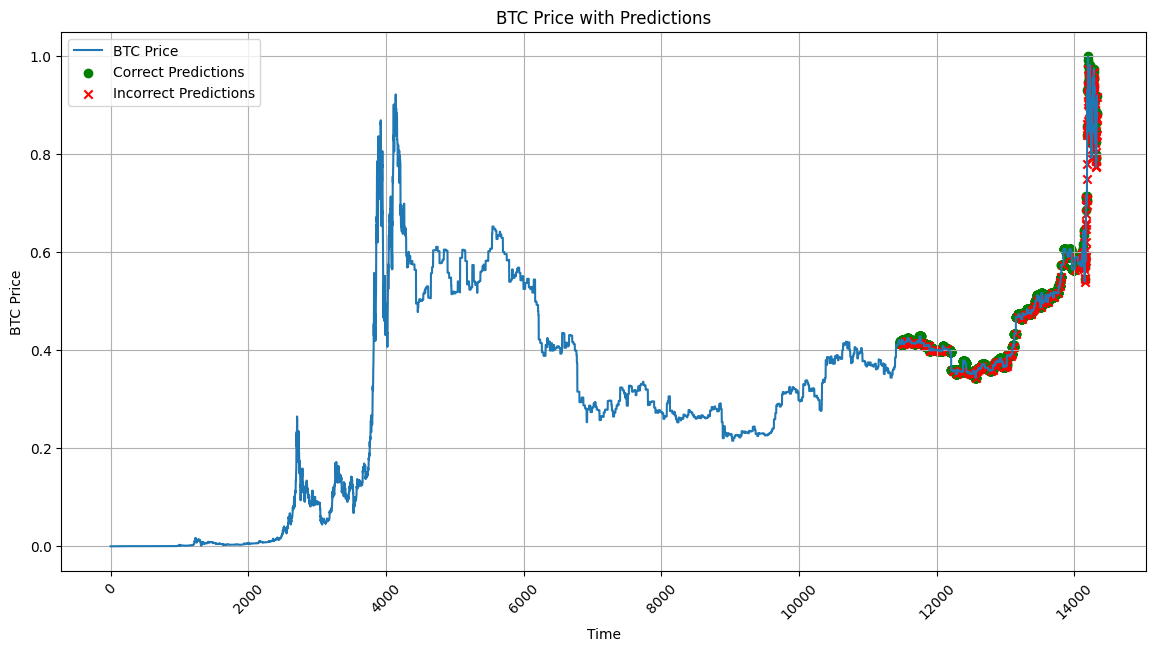

In [11]:

import matplotlib.pyplot as plt

# Convert predictions and actual values to DataFrame
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}, index=X_test.index)

# Plot BTC price
plt.figure(figsize=(14,7))
plt.plot(df.index, df['close'], label='BTC Price')

# Mark correct predictions
correct_predictions = results[results['Actual'] == results['Predicted']]
incorrect_predictions = results[results['Actual'] != results['Predicted']]

# Ensure indices are valid for plotting
valid_correct_indices = correct_predictions.index.intersection(df.index)
valid_incorrect_indices = incorrect_predictions.index.intersection(df.index)

if not valid_correct_indices.empty:
    plt.scatter(valid_correct_indices, df.loc[valid_correct_indices, 'close'], color='green', label='Correct Predictions', marker='o')

if not valid_incorrect_indices.empty:
    plt.scatter(valid_incorrect_indices, df.loc[valid_incorrect_indices, 'close'], color='red', label='Incorrect Predictions', marker='x')

plt.title('BTC Price with Predictions')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
